In [9]:
import pandas as pd
import numpy as np
import yfinance as yf
from statsforecast import StatsForecast
from statsforecast.models import  Naive, AutoARIMA, AutoCES, AutoTheta, AutoETS
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datasetsforecast.losses import mae
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

In [10]:
warnings.filterwarnings("ignore")

In [11]:
tickers = ['BTC-USD', 'NVDA', 'IBM'] 
df = yf.download(tickers, start = '2018-01-01', end = '2022-12-31', interval='1wk')
df.head()

[                       0%%                      ]

[*********************100%%**********************]  3 of 3 completed


Price          Adj Close                               Close              \
Ticker           BTC-USD         IBM      NVDA       BTC-USD         IBM   
Date                                                                       
2018-01-01  16477.599609  114.265404  5.327617  16477.599609  155.344162   
2018-01-08  13772.000000  114.722481  5.515099  13772.000000  155.965576   
2018-01-15  11600.099609  114.181023  5.691447  11600.099609  155.229446   
2018-01-22  11786.299805  117.676010  6.018426  11786.299805  159.980881   
2018-01-29   8277.009766  111.832291  5.775789   8277.009766  152.036331   

Price                        High                                Low  \
Ticker         NVDA       BTC-USD         IBM     NVDA       BTC-USD   
Date                                                                   
2018-01-01  5.38500  17712.400391  155.736145  5.45125  13154.700195   
2018-01-08  5.57450  16537.900391  157.686417  5.65675  13105.900391   
2018-01-15  5.75275  14445.500000  163.604202  5.77725   9402.290039   
2018-01-22  6.08325  12040.299805  161.300186  6.08350  10129.700195   
2018-01-29  5.83800  11875.599609  160.984711  6.23175   7796.490234   

Price                                    Open                       \
Ticker             IBM     NVDA       BTC-USD         IBM     NVDA   
Date                                                                 
2018-01-01  146.787766  4.86250  14112.200195  147.705551  4.89450   
2018-01-08  154.588913  5.40000  16476.199219  155.506699  5.51000   
2018-01-15  154.206497  5.41725  13767.299805  157.839386  5.60125   
2018-01-22  154.024857  5.70250  11633.099609  154.407272  5.76075   
2018-01-29  151.883362  5.77925  11755.500000  160.086044  6.06850   

Price             Volume                        
Ticker           BTC-USD       IBM        NVDA  
Date                                            
2018-01-01  123814400000  27610321  2433712000  
2018-01-08  106022199296  23618471  2726828000  
2018-01-15   97932879872  57463056  2258768000  
2018-01-22   64691999232  30001790  2532384000  
2018-01-29   60810019840  23198397  2742212000

In [12]:
df = df.loc[:, (['Adj Close'], tickers)]
df.columns = df.columns.droplevel() 
df = df.reset_index()
df.head()

Ticker,Date,BTC-USD,NVDA,IBM
0,2018-01-01,16477.599609,5.327617,114.265404
1,2018-01-08,13772.000000,5.515099,114.722481
2,2018-01-15,11600.099609,5.691447,114.181023
3,2018-01-22,11786.299805,6.018426,117.676010
4,2018-01-29,8277.009766,5.775789,111.832291


In [13]:
prices = df.melt(id_vars = 'Date')
prices = prices.rename(columns={'Date': 'ds', 'Ticker': 'unique_id', 'value': 'y'})
prices = prices[['unique_id', 'ds', 'y']]
prices

,unique_id,ds,y
0,BTC-USD,2018-01-01,16477.599609
1,BTC-USD,2018-01-08,13772.000000
2,BTC-USD,2018-01-15,11600.099609
3,BTC-USD,2018-01-22,11786.299805
4,BTC-USD,2018-01-29,8277.009766
...,...,...,...
778,IBM,2022-11-28,138.976425
779,IBM,2022-12-05,137.462067
780,IBM,2022-12-12,131.021301
781,IBM,2022-12-19,132.414154


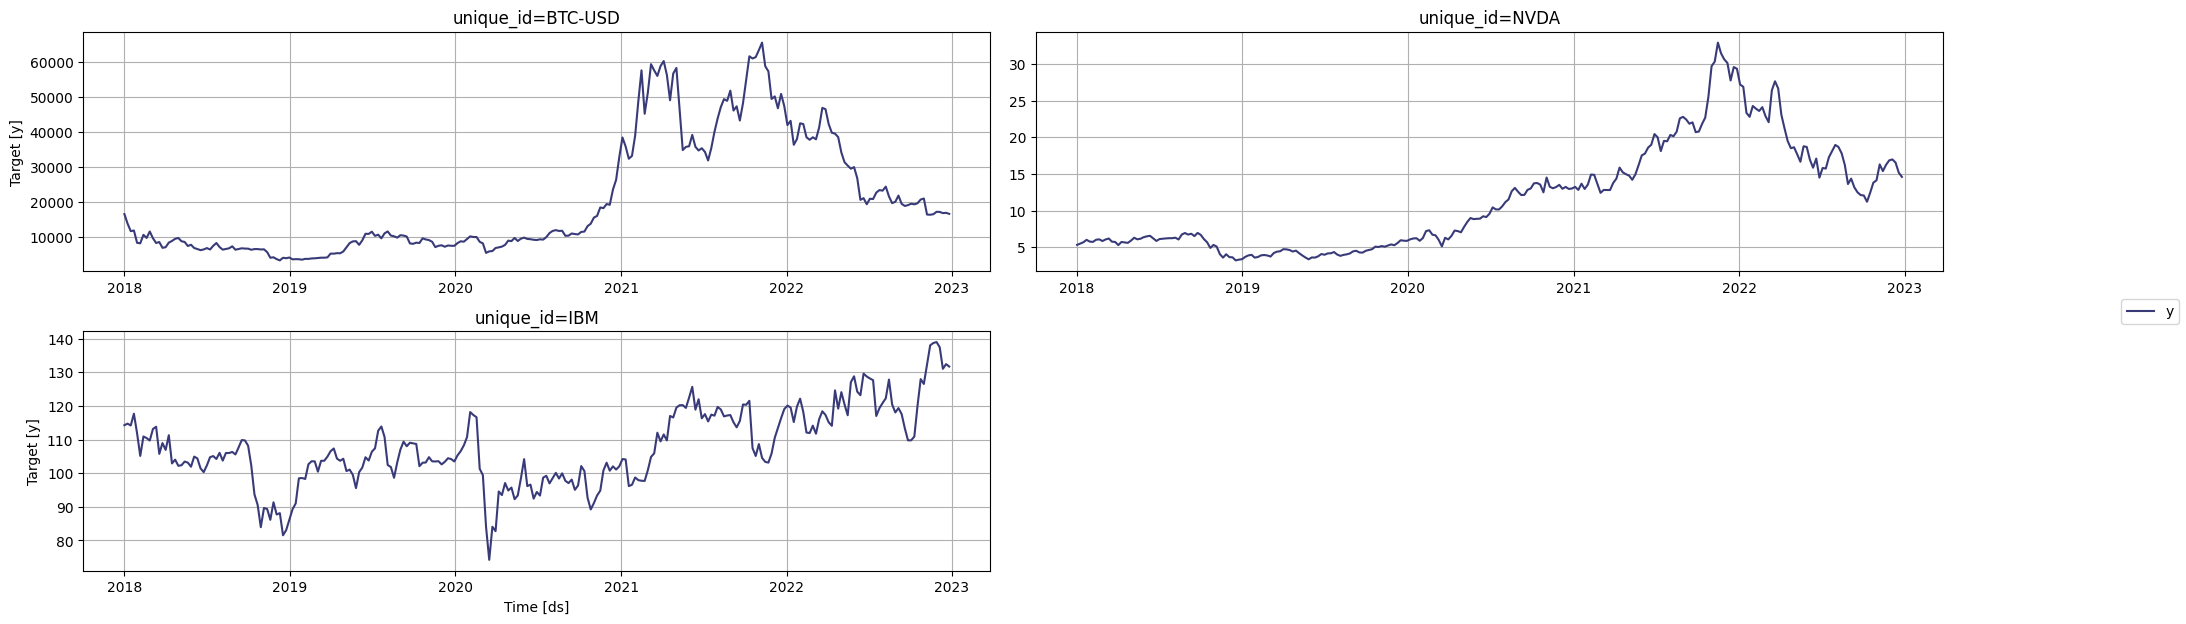

In [14]:
StatsForecast.plot(prices)

In [15]:
prices['rt'] = prices['y'].div(prices.groupby('unique_id')['y'].shift(1))
prices['rt'] = np.log(prices['rt'])

returns = prices[['unique_id', 'ds', 'rt']]
returns = returns.rename(columns={'rt':'y'})
returns = returns.dropna(subset=['y'])
returns

,unique_id,ds,y
1,BTC-USD,2018-01-08,-0.179364
2,BTC-USD,2018-01-15,-0.171624
3,BTC-USD,2018-01-22,0.015924
4,BTC-USD,2018-01-29,-0.353456
5,BTC-USD,2018-02-05,-0.017925
...,...,...,...
778,IBM,2022-11-28,0.002020
779,IBM,2022-12-05,-0.010956
780,IBM,2022-12-12,-0.047988
781,IBM,2022-12-19,0.010575


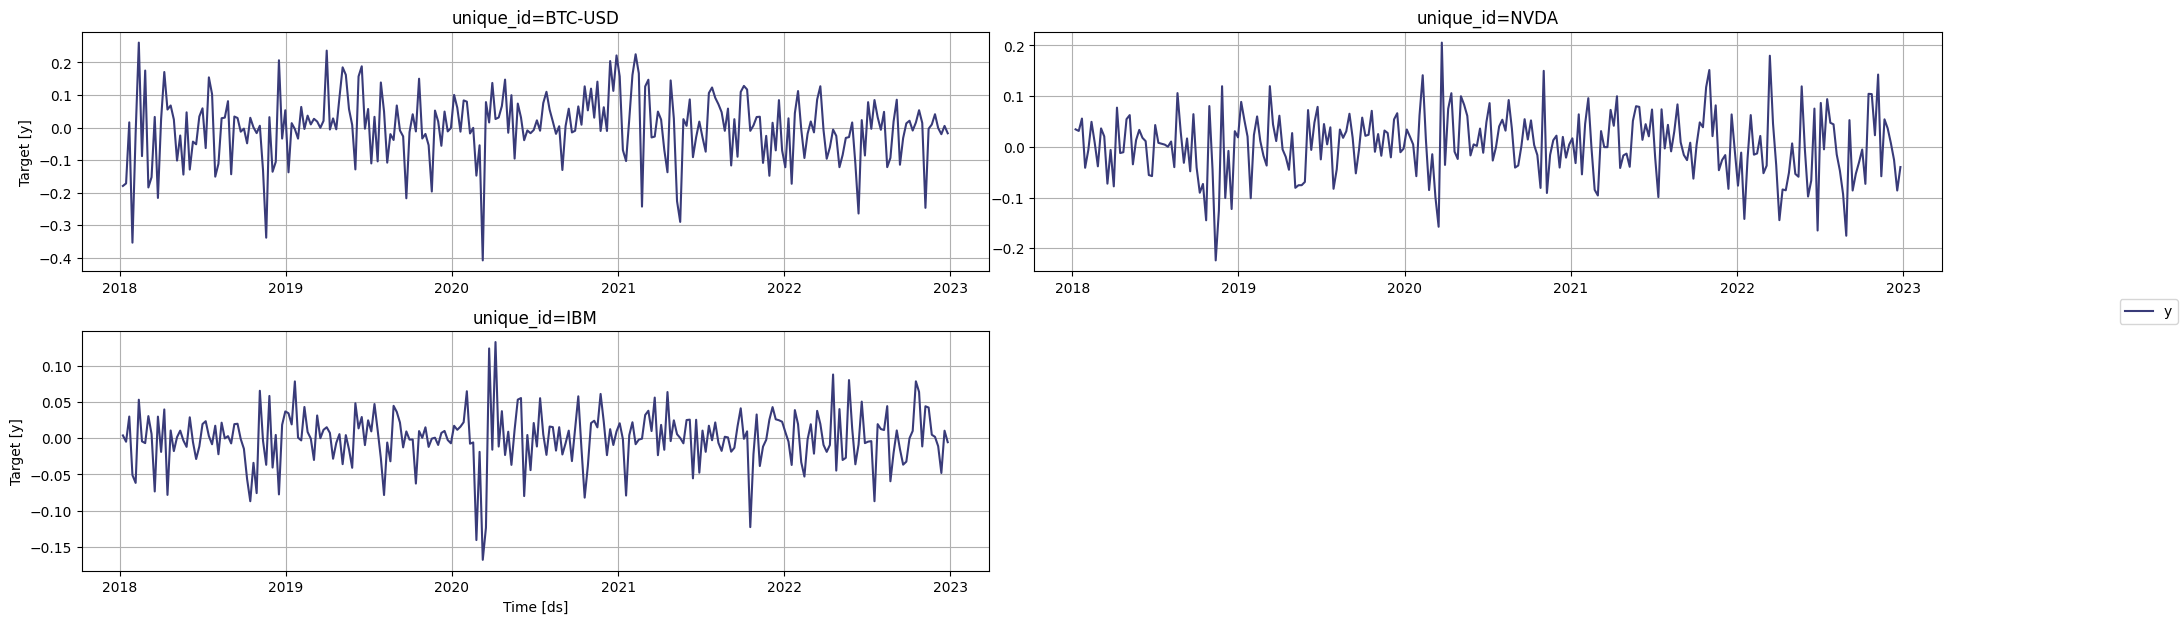

In [16]:
StatsForecast.plot(returns)

<Figure size 1500x2000 with 0 Axes>

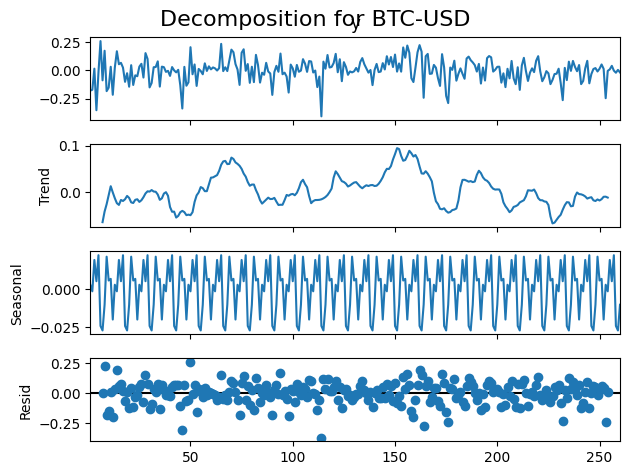

<Figure size 1500x2000 with 0 Axes>

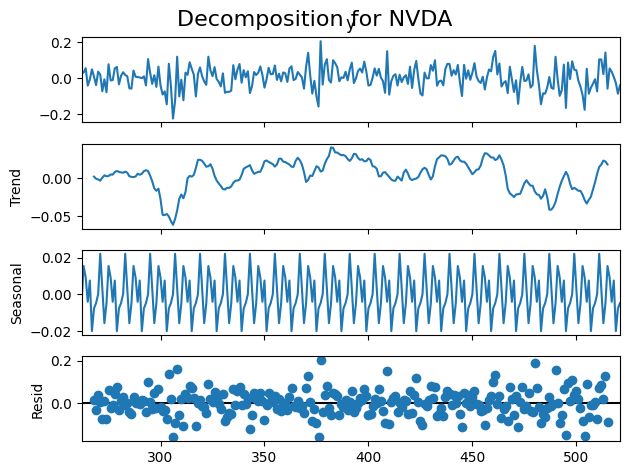

<Figure size 1500x2000 with 0 Axes>

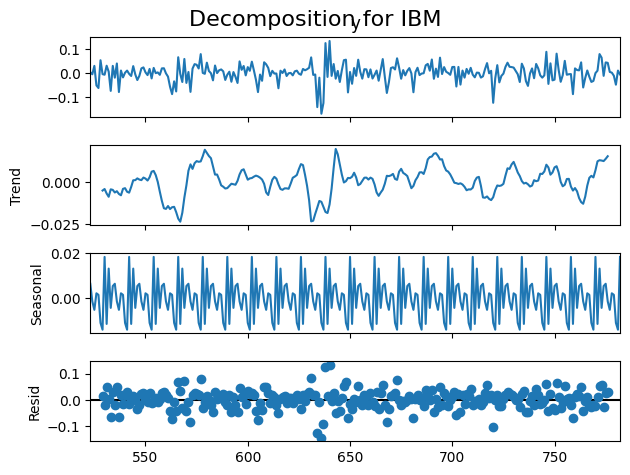

In [17]:
# Descomposición estacional
unique_ids = returns['unique_id'].unique()

for unique_id in unique_ids:
    series = returns[returns['unique_id'] == unique_id]
    
    # Asegurarse de que hay suficientes datos para la descomposición
    if len(series) >= 24:  # Al menos dos años de datos mensuales
        decomposition = seasonal_decompose(series['y'], model='additive', period=12)
        
        # Graficar
        plt.figure(figsize=(15, 20))
        decomposition.plot()
        plt.suptitle(f'Decomposition for {unique_id}', fontsize=16)
        plt.show()
    else:
        print(f"Not enough data to decompose for {unique_id}")

In [20]:
models = [Naive(), AutoCES(), AutoETS(), AutoTheta(), AutoARIMA()]

sf = StatsForecast(
    df = returns, 
    models = models, 
    freq = 'W',
    n_jobs = -1
)
sf.fit()

StatsForecast(models=[Naive,CES,AutoETS,AutoTheta,AutoARIMA])

Modelo: Naive
No residuals found for Naive
Modelo: AutoCES


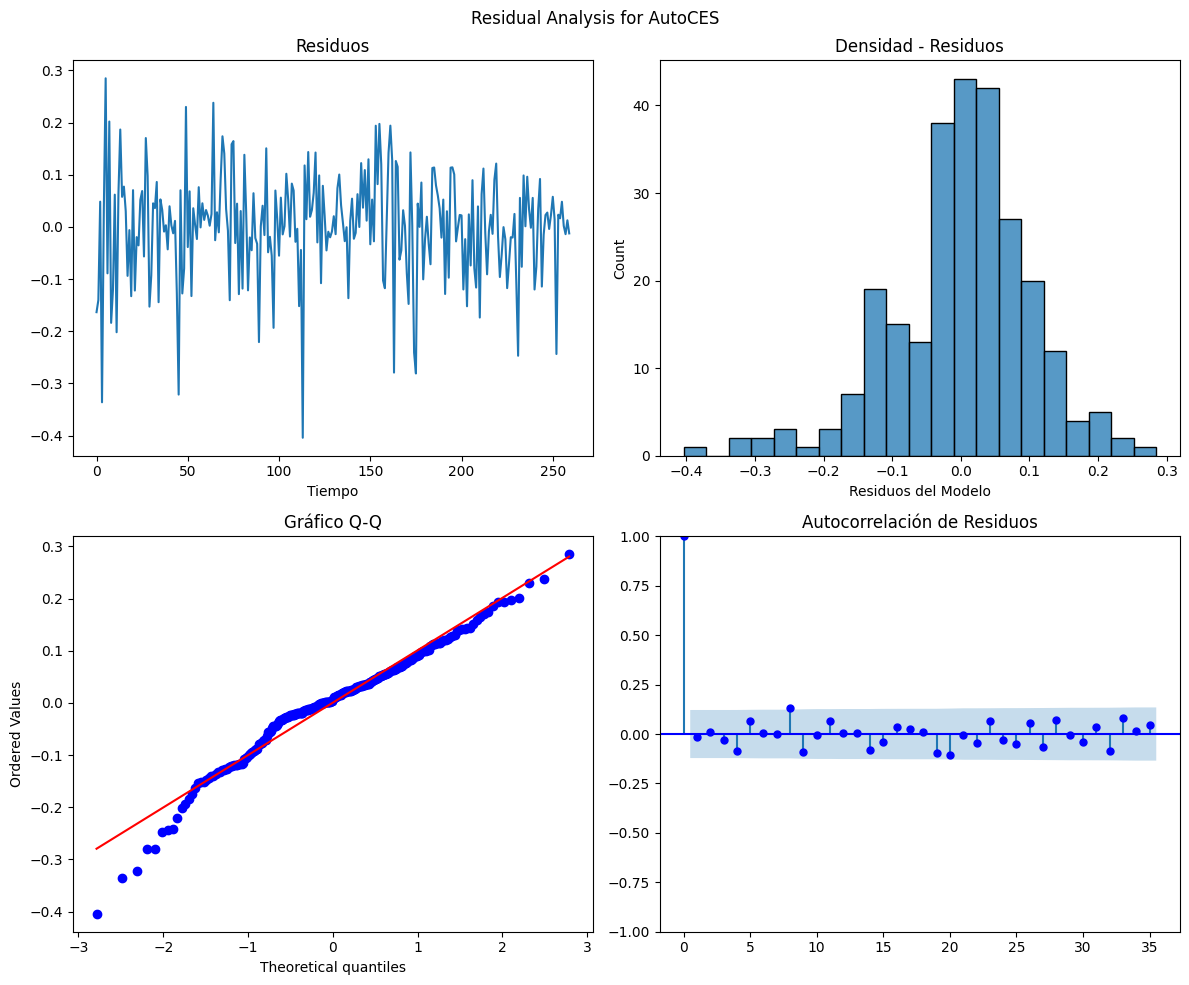

Modelo: AutoETS


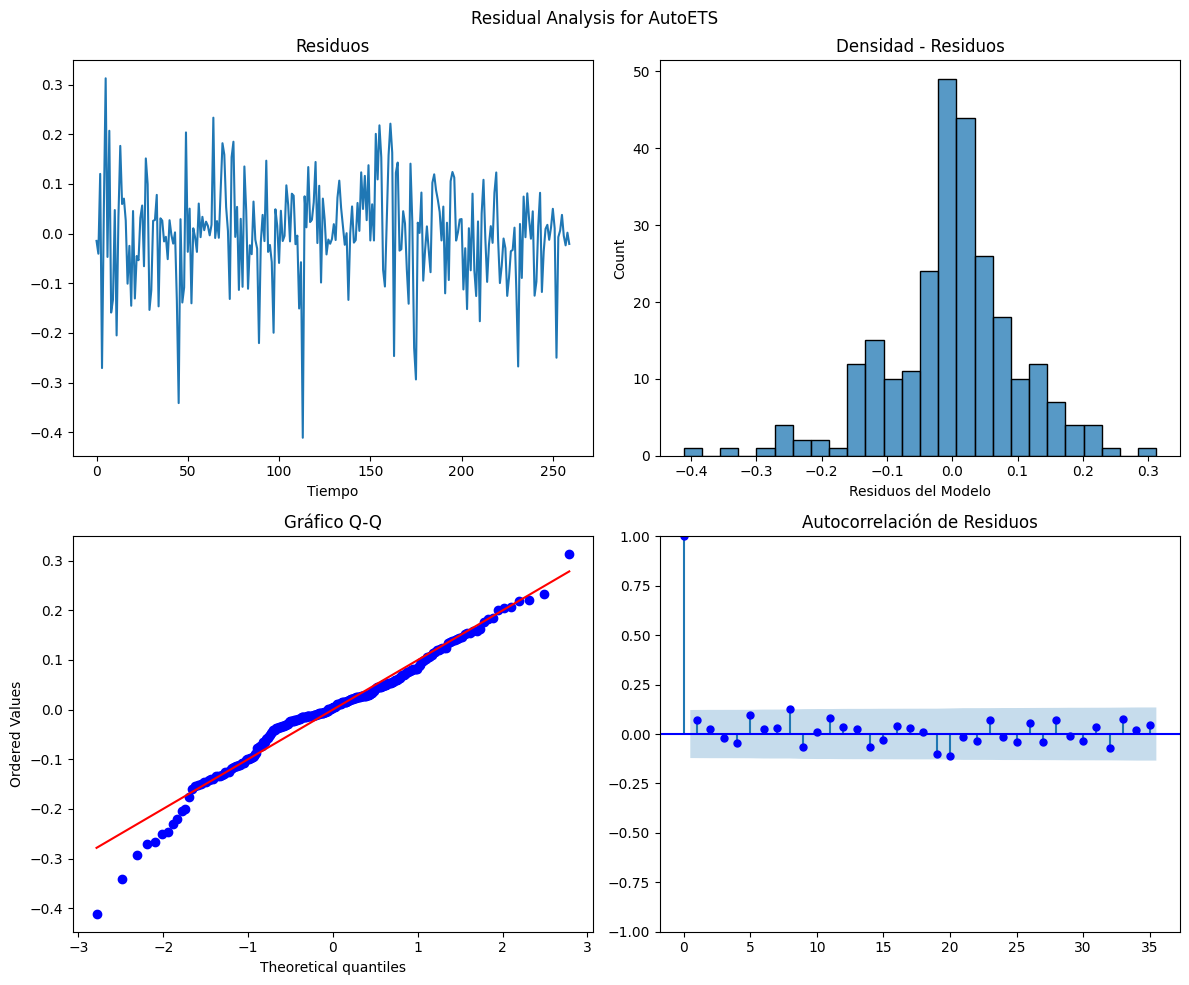

Modelo: AutoTheta


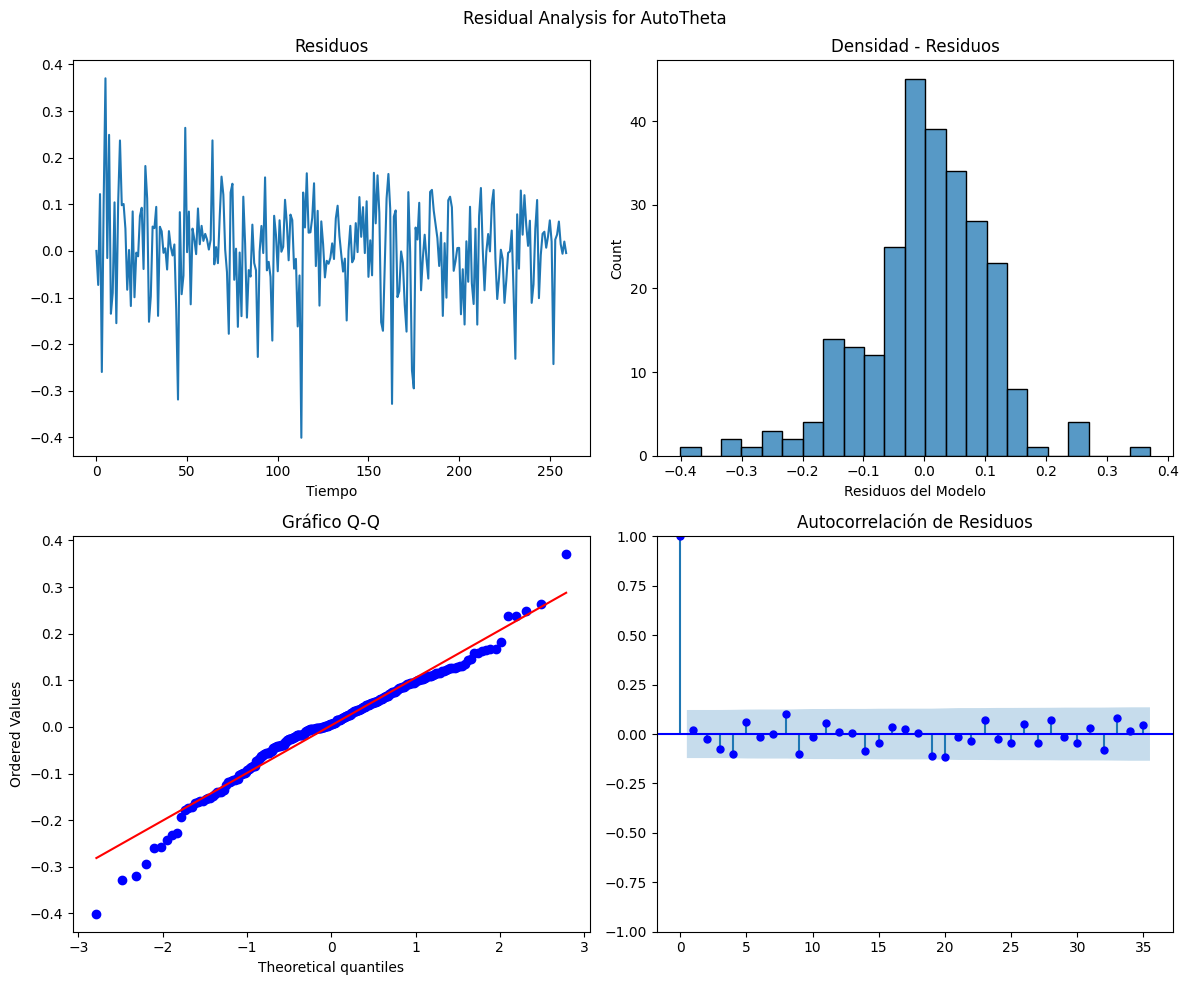

Modelo: AutoARIMA
(0, 1, 0, 0, 1, 0, 0)


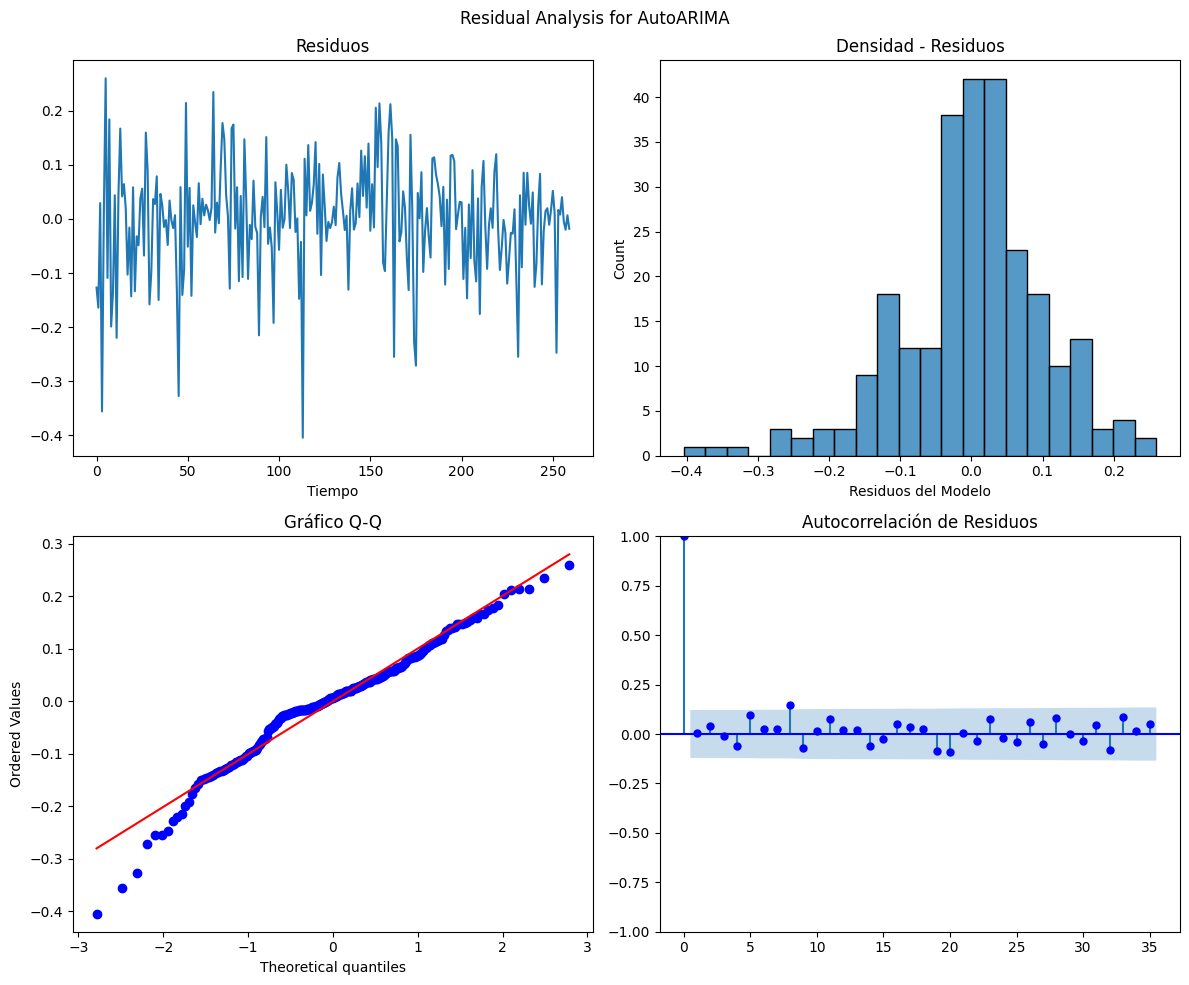

In [21]:
# Convertir sf.fitted_ a un diccionario
fitted_dict = {model_name: model_result for model_name, model_result in zip(models, sf.fitted_[0])}

# Iterar sobre los modelos ajustados y visualizar los residuos
for model in models:
    model_name = type(model).__name__
    model_result = fitted_dict[model]
    
    print(f"Modelo: {model_name}")

    # Verificar si el modelo tiene residuals
    if 'residuals' in model_result.model_:
        # Imprimir los componentes del modelo si están disponibles
        if 'arma' in model_result.model_:
            print(model_result.model_['arma'])

        # Residuales del modelo
        residual = pd.DataFrame(model_result.model_.get("residuals"), columns=["Residuos del Modelo"])

        # Visualización de los residuos
        fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

        # Residuales a lo largo del tiempo
        residual['Residuos del Modelo'].plot(ax=axs[0, 0])
        axs[0, 0].set_title("Residuos")
        axs[0, 0].set_xlabel('Tiempo')

        # Histograma de los residuos
        sns.histplot(residual['Residuos del Modelo'], ax=axs[0, 1])
        axs[0, 1].set_title("Densidad - Residuos")

        # Gráfico Q-Q
        stats.probplot(residual['Residuos del Modelo'], dist="norm", plot=axs[1, 0])
        axs[1, 0].set_title('Gráfico Q-Q')

        # ACF de los residuos
        plot_acf(residual['Residuos del Modelo'], lags=35, ax=axs[1, 1], color="blue")
        axs[1, 1].set_title("Autocorrelación de Residuos")

        plt.suptitle(f'Residual Analysis for {model_name}')
        plt.tight_layout()
        plt.show()
    else:
        print(f"No residuals found for {model_name}")

In [22]:
crossvalidation_df = sf.cross_validation(
    df = returns,
    h = 3,
    step_size = 3,
    n_windows = 4
  )

In [ ]:
crossvalidation_df = crossvalidation_df.reset_index()
crossvalidation_df.rename(columns = {'y' : 'actual'}, inplace = True)
crossvalidation_df.head()

In [ ]:
StatsForecast.plot(returns, crossvalidation_df.drop(['cutoff', 'actual'], axis=1))

In [ ]:
def compute_cv_mae(crossvalidation_df):
    """Compute MAE for all models generated"""
    res = {}
    for mod in models: 
        res[mod] = mae(crossvalidation_df['actual'], crossvalidation_df[str(mod)])
    return pd.Series(res)


mae_cv = crossvalidation_df.groupby(['unique_id', 'cutoff']).apply(compute_cv_mae)

mae = mae_cv.groupby('unique_id').mean()
mae